In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import wilcoxon 
from Bio.PDB import *
import os

from pylab import rcParams
from scipy.stats import chi2_contingency

# modules and functions

def is_float(elem):
    try:
        elem = float(elem)
        out = True
    except:
        elem = elem
        out = False
    return out
    

def calc_U(one, two):
    try:
        scipy_U = sp.stats.mannwhitneyu(one, two, alternative="two-sided", use_continuity=False)
        # Formula for the relation between AUC and the U statistic
        AUC = scipy_U.statistic/ (len(one)*len(two))
        pval = scipy_U.pvalue
        if AUC < 0.5:
            AUC = 1-AUC
            
        return round(AUC,3), pval
    except:
        return [np.nan, np.nan]

colormap = {'A':'#B8321A', 'C':'#44781E',
            'Compensator':"#4F651D", 'ExplicitControl':"#2F638F", 'Background':"#E5BF86",
           'GeneralControl':"#565052",'Wonder':"#C582B2", 'no_type':"#E5BF86",
           'Not compensated':'#2F414B','Compensated':'#AD6B17',
           'Not compensator':'#7C6C65',
           'Surface':"#DD3C51", 'Core':"#313657", 'PPI':"#1F6683", 
           
           'Protein interaction':"#1F6683", 
           'ligand interaction':'#B09B37',
           'Non-universal':'#B09B37',
           'Universal':"#DD3C51"}




three2one = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}





def plot_hist(hue_list, data, col_hue, col_data, mode,figsize):
    # hue_list - list with hues (different hists)
    # data - name of df
    # col_hue - name of column where separate by hue
    # col_data - name of column, where to find data
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    
    text = []
    plt.figure(figsize=figsize)
    
    for elem in hue_list:
        one = data[col_data][data[col_hue] == elem]
        sns.kdeplot(x = one, label=elem, color= colormap[elem],fill=True,
                   bw_adjust = 3)
        plt.axvline(x=np.median(one), color = colormap[elem])
        text.append(elem+' N=' + str(len(one)) + ' median=' + 
                    str(round(np.nanmedian(one),2))+'\n')
    
    plt.xlabel(col_data)
        
    if mode == 'wilcoxon':
        p_val = wilcoxon(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+str(round(p_val,5)))
        
    if mode == 'mann':
        p_val = calc_U(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+"{:6.3e}".format(p_val))
        
    
    plt.title(' '.join(text))   
    plt.legend()
    return plt
    #plt.show()



def plot_hist_bar(hue_list, data, col_hue, col_data, mode,figsize,bins, fill=False):
    # hue_list - list with hues (different hists)
    # data - name of df
    # col_hue - name of column where separate by hue
    # col_data - name of column, where to find data
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    data = data[data[col_hue].isin(hue_list)]
    text = []
    plt.figure(figsize=figsize)
   
    for elem in hue_list:
        one = data[col_data][data[col_hue] == elem]
        
        plt.axvline(x=np.median(one), color = colormap[elem])
        text.append(elem+' N=' + str(len(one)) + ' median=' + 
                    str(round(np.nanmedian(one),2))+'\n')
                    
    
    sns.histplot(data = data, x=col_data, hue=col_hue, palette = colormap,
                 common_norm=False,stat="density",bins=bins,element='step',fill=fill,
                )
    
    
    
    
    plt.xlabel(col_data)
        
    if mode == 'wilcoxon':
        p_val = wilcoxon(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+str(round(p_val,5)))
        
    if mode == 'mann':
        p_val = calc_U(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+"{:6.3e}".format(p_val))
        
    
    plt.title(' '.join(text))   
    #plt.legend()
    return plt
    #plt.show()




def plot_many_hists(hue_list, data,figure_list, col_figure, mode, 
                   figsize):
    # hue_list - list with colnames for hues
    # data - name of df
    # figure_list - list of hues (for different figures)
    # col_figure - name of column where separate by figs
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    n_rows = len(figure_list)//2
    if len(figure_list)%2 != 0:
        n_rows += 1
    i = 0
    fig, axs = plt.subplots(n_rows,2,figsize=figsize)
    for elem in figure_list:
        i1 = i//2
        i2 = i%2
        i+=1
        
        one = data[data[col_figure] == elem][hue_list[0]]
        two = data[data[col_figure] == elem][hue_list[1]]
        one_label = 'A' #A
        two_label = 'C' #C
        #sns.distplot(ax = axs[i1, i2], a=one, bins=10, label=one_label, hist=True,
                    # color=colormap[one_label])
        
        sns.kdeplot(ax = axs[i1, i2], x = one, label=one_label, 
                    color= colormap[one_label],fill=True, bw_adjust = 3)
        
        sns.kdeplot(ax = axs[i1, i2], x = two, label=two_label, 
                    color= colormap[two_label],fill=True, bw_adjust = 3)
        
        # Plot median
        axs[i1, i2].axvline(x=np.nanmedian(one), color = colormap[one_label])
        axs[i1, i2].axvline(x=np.nanmedian(two),color = colormap[two_label])
        one_text = one_label + ' N=' + str(len(one)) + ' median=' + str(round(np.nanmedian(one),2))
        two_text = two_label + ' N=' + str(len(two)) + ' median=' + str(round(np.nanmedian(two),2))
        
        
        if mode == 'wilcoxon':
            p_val = wilcoxon(one,two)[1]
            
        if mode == 'mann':
            p_val = calc_U(one,two)[1]
       
        
        
        axs[i1, i2].set_title(elem+'\n'+one_text + '\n' + two_text+'\n p-val '+
                             "{:6.3e}".format(p_val))
        #axs[i1, i2].set_xlabel(col_figure)
        axs[i1, i2].legend()

    fig.tight_layout(pad=3.0)
    return plt




def rename_bad(elem):
    if elem == 'Compensator':
        return 'Compensated'
    else:
        return 'Not compensated'
    
def rename_neutral(elem):
    if elem != 'Compensator':
        return 'Not compensator'
    else:
        return 'Compensator'
    

In [2]:
import sys
sys.path.append('../')
import pics_module as pics

In [3]:
! pwd

/Users/azbukinanadezda/Google Диск/Ramensky_lab/Compensatory_project/Papers/MCCMB21


In [4]:
compeletename = '/Users/azbukinanadezda/Google Диск/Ramensky_lab/Compensatory_project/Papers/MCCMB21/' 

In [5]:


df = pd.read_csv('../../CPD_data_06_07_21_for_VER_ddG.tsv.gz',sep='\t')

for elem in df.columns:
    df = df.rename(columns={elem:elem.replace('.','_')})
df.head()

,#Pair_Type,Dataset,Uniprot_AC,Pos_A,A1,A2,Pos_C,C1,C2,Score_A,Score_C,Score_AC,PMD_Phen,Effect_A,Effect_C,Effect_AC,Max_PDB_ID_A,Max_Chain_A,Max_Residue-ID_A,Max_Residue_AA_type_A,Max_Sequence_identity_A,Max_Coverage_A,Max_Resolution_A,Max_RIN_A,Max_Chain_interaction_partners_A,Max_Small_molecules_partners_A,Short_Max_RIN_A,Max_Iden_A1 match,Max_PDB_ID_C,Max_Chain_C,Max_Residue-ID_C,Max_Residue_AA_type_C,Max_Sequence_identity_C,Max_Coverage_C,Max_Resolution_C,Max_RIN_C,Max_Chain_interaction_partners_C,Max_Small_molecules_partners_C,Short_Max_RIN_C,Max_Iden_C1_match,Rec_PDB_ID_A,Rec_Chain_A,Rec_Residue-ID_A,Rec_Residue_AA_type_A,Rec_Sequence_identity_A,Rec_Coverage_A,Rec_Resolution_A,Rec_RIN_A,Rec_Chain_interaction_partners_A,Rec_Small_molecules_partners_A,Short_Rec_RIN_A,Rec_A1_match,Rec_PDB_ID_C,Rec_Chain_C,Rec_Residue-ID_C,Rec_Residue_AA_type_C,Rec_Sequence_identity_C,Rec_Coverage_C,Rec_Resolution_C,Rec_RIN_C,Rec_Chain_interaction_partners_C,Rec_Small_molecules_partners_C,Short_Rec_RIN_C,Rec_C1_match,Max_Chain_partners_A,Max_Chain_partners_C,Rec_Chain_partners_A,Rec_PDB_AA_C,Rec_Chain_partners_C,id_pair_Max,id_A_Max,id_C_Max,id_pair_Rec,id_A_Rec,id_C_Rec
0,Background,maveDB_2,P63279,106,A,E,74,K,D,-3.15209,0.421136,-4.32193,?,bad,neutral,bad,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,74,K,1,1,2.8,Surface,?,?,Surface,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,3uip,A,74,K,1,0.993671,2.29,Protein interaction,C,?,PPI,1,?,?,?,?,?,0,590749,601189,0,370476,380247
1,Background,maveDB_2,P63279,106,A,I,67,D,T,-1.46562,-0.649785,-2.00309,?,bad,neutral,bad,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,67,D,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,67,D,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,1,590750,590931,1,370477,370646
2,Background,maveDB_2,P63279,106,A,T,78,E,G,-0.200297,-0.0721246,0.71154,?,neutral,neutral,neutral,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,78,E,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,78,E,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,2,590751,601190,2,370478,380248
3,Background,maveDB_2,P63279,106,A,T,40,N,D,-0.200297,0.16965,-0.0213069,?,neutral,neutral,neutral,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,40,N,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,40,N,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,3,590751,601191,3,370478,380249
4,Background,maveDB_2,P63279,26,A,G,106,A,T,-1.10596,-0.200297,-0.791497,?,bad,neutral,neutral,1a3s,A,26,A,1,1,2.8,Core,?,?,Core,1,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,26,A,1,1,2.5,Core,?,?,Core,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,?,?,?,?,?,4,590752,590751,?,?,?


In [6]:
dfg = pd.read_csv('../../maveDB-080721-biounit-single.foldx.out.tsv.gz',sep='\t')
dfg.head()

,#ID,SD,Ave_Total,Ave_Internal,Ave_Interaction,Backbone_Hbond,Sidechain_Hbond,Van_Der_Waals,Electrostatics,Solvation_Polar,Solvation_Hydrophobic,Van_Der_Waals_Clashes,Entropy_Sidechain,Entropy_Mainchain,Sloop_entropy,Mloop_entropy,Cis_bond,Torsional_Clash,Backbone_Clash,Helix_Dipole,Water_Bridge,Disulfide,Electrostatic_Kon,Partial_Covalent_Bonds,Energy_Ionisation,Entropy_Complex
0,0,0.054254,-0.529446,-0.5425,0.0185,-0.778798,-7.301880e-01,-0.759582,-0.208554,1.062920,-0.982569,1.738660e-03,1.306130,0.351709,0,0,0.0,0.017055,0.212372,0.076499,0,0.0,1.141930e-01,0.0,7.401490e-17,0
1,1,0.000951,0.236297,0.275,0,-0.051707,1.847410e-13,-0.490404,-0.051528,0.529357,-0.661811,2.837330e-03,0.336673,0.215322,0,0,0.0,0.407456,0.226354,0.000101,0,0.0,-2.338870e-14,0.0,-7.401490e-17,0
2,2,0.000300,0.837819,0.8372,0,0.000000,0.000000e+00,-0.307043,0.008522,0.618036,-0.289130,4.869430e-02,0.299978,0.251325,0,0,0.0,0.207435,0.113524,0.000000,0,0.0,0.000000e+00,0.0,0.000000e+00,0
3,3,0.000300,0.837819,0.8372,0,0.000000,0.000000e+00,-0.307043,0.008522,0.618036,-0.289130,4.869430e-02,0.299978,0.251325,0,0,0.0,0.207435,0.113524,0.000000,0,0.0,0.000000e+00,0.0,0.000000e+00,0
4,4,0.020625,0.796163,1.0603,-0.1771,0.000000,4.752430e-01,-0.279249,-0.136200,0.099672,-0.342072,-1.184240e-15,0.408653,0.403184,0,0,0.0,0.008227,0.028518,0.160921,0,0.0,-5.100080e-02,0.0,4.878250e-02,0


In [7]:
dfg['#ID'] = dfg['#ID'].astype(str)

In [8]:
df.shape

(671773, 75)

In [9]:
df = pd.merge(df, dfg[['#ID', 'Ave_Total']], how='left', left_on='id_pair_Rec', right_on='#ID')
df = df.rename(columns={'Ave_Total':'ddG_pair_Rec'})
df = df.drop('#ID', axis=1)
df.head()

,#Pair_Type,Dataset,Uniprot_AC,Pos_A,A1,A2,Pos_C,C1,C2,Score_A,Score_C,Score_AC,PMD_Phen,Effect_A,Effect_C,Effect_AC,Max_PDB_ID_A,Max_Chain_A,Max_Residue-ID_A,Max_Residue_AA_type_A,Max_Sequence_identity_A,Max_Coverage_A,Max_Resolution_A,Max_RIN_A,Max_Chain_interaction_partners_A,Max_Small_molecules_partners_A,Short_Max_RIN_A,Max_Iden_A1 match,Max_PDB_ID_C,Max_Chain_C,Max_Residue-ID_C,Max_Residue_AA_type_C,Max_Sequence_identity_C,Max_Coverage_C,Max_Resolution_C,Max_RIN_C,Max_Chain_interaction_partners_C,Max_Small_molecules_partners_C,Short_Max_RIN_C,Max_Iden_C1_match,Rec_PDB_ID_A,Rec_Chain_A,Rec_Residue-ID_A,Rec_Residue_AA_type_A,Rec_Sequence_identity_A,Rec_Coverage_A,Rec_Resolution_A,Rec_RIN_A,Rec_Chain_interaction_partners_A,Rec_Small_molecules_partners_A,Short_Rec_RIN_A,Rec_A1_match,Rec_PDB_ID_C,Rec_Chain_C,Rec_Residue-ID_C,Rec_Residue_AA_type_C,Rec_Sequence_identity_C,Rec_Coverage_C,Rec_Resolution_C,Rec_RIN_C,Rec_Chain_interaction_partners_C,Rec_Small_molecules_partners_C,Short_Rec_RIN_C,Rec_C1_match,Max_Chain_partners_A,Max_Chain_partners_C,Rec_Chain_partners_A,Rec_PDB_AA_C,Rec_Chain_partners_C,id_pair_Max,id_A_Max,id_C_Max,id_pair_Rec,id_A_Rec,id_C_Rec,ddG_pair_Rec
0,Background,maveDB_2,P63279,106,A,E,74,K,D,-3.15209,0.421136,-4.32193,?,bad,neutral,bad,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,74,K,1,1,2.8,Surface,?,?,Surface,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,3uip,A,74,K,1,0.993671,2.29,Protein interaction,C,?,PPI,1,?,?,?,?,?,0,590749,601189,0,370476,380247,-0.529446
1,Background,maveDB_2,P63279,106,A,I,67,D,T,-1.46562,-0.649785,-2.00309,?,bad,neutral,bad,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,67,D,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,67,D,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,1,590750,590931,1,370477,370646,0.236297
2,Background,maveDB_2,P63279,106,A,T,78,E,G,-0.200297,-0.0721246,0.71154,?,neutral,neutral,neutral,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,78,E,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,78,E,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,2,590751,601190,2,370478,380248,0.837819
3,Background,maveDB_2,P63279,106,A,T,40,N,D,-0.200297,0.16965,-0.0213069,?,neutral,neutral,neutral,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,40,N,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,40,N,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,3,590751,601191,3,370478,380249,0.837819
4,Background,maveDB_2,P63279,26,A,G,106,A,T,-1.10596,-0.200297,-0.791497,?,bad,neutral,neutral,1a3s,A,26,A,1,1,2.8,Core,?,?,Core,1,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,26,A,1,1,2.5,Core,?,?,Core,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,?,?,?,?,?,4,590752,590751,?,?,?,NaN


In [10]:
df = pd.merge(df, dfg[['#ID', 'Ave_Total']], how='left', left_on='id_A_Rec', right_on='#ID')
df = df.rename(columns={'Ave_Total':'ddG_A_Rec'})
df = df.drop('#ID', axis=1)
df.head()

,#Pair_Type,Dataset,Uniprot_AC,Pos_A,A1,A2,Pos_C,C1,C2,Score_A,Score_C,Score_AC,PMD_Phen,Effect_A,Effect_C,Effect_AC,Max_PDB_ID_A,Max_Chain_A,Max_Residue-ID_A,Max_Residue_AA_type_A,Max_Sequence_identity_A,Max_Coverage_A,Max_Resolution_A,Max_RIN_A,Max_Chain_interaction_partners_A,Max_Small_molecules_partners_A,Short_Max_RIN_A,Max_Iden_A1 match,Max_PDB_ID_C,Max_Chain_C,Max_Residue-ID_C,Max_Residue_AA_type_C,Max_Sequence_identity_C,Max_Coverage_C,Max_Resolution_C,Max_RIN_C,Max_Chain_interaction_partners_C,Max_Small_molecules_partners_C,Short_Max_RIN_C,Max_Iden_C1_match,Rec_PDB_ID_A,Rec_Chain_A,Rec_Residue-ID_A,Rec_Residue_AA_type_A,Rec_Sequence_identity_A,Rec_Coverage_A,Rec_Resolution_A,Rec_RIN_A,Rec_Chain_interaction_partners_A,Rec_Small_molecules_partners_A,Short_Rec_RIN_A,Rec_A1_match,Rec_PDB_ID_C,Rec_Chain_C,Rec_Residue-ID_C,Rec_Residue_AA_type_C,Rec_Sequence_identity_C,Rec_Coverage_C,Rec_Resolution_C,Rec_RIN_C,Rec_Chain_interaction_partners_C,Rec_Small_molecules_partners_C,Short_Rec_RIN_C,Rec_C1_match,Max_Chain_partners_A,Max_Chain_partners_C,Rec_Chain_partners_A,Rec_PDB_AA_C,Rec_Chain_partners_C,id_pair_Max,id_A_Max,id_C_Max,id_pair_Rec,id_A_Rec,id_C_Rec,ddG_pair_Rec,ddG_A_Rec
0,Background,maveDB_2,P63279,106,A,E,74,K,D,-3.15209,0.421136,-4.32193,?,bad,neutral,bad,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,74,K,1,1,2.8,Surface,?,?,Surface,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,3uip,A,74,K,1,0.993671,2.29,Protein interaction,C,?,PPI,1,?,?,?,?,?,0,590749,601189,0,370476,380247,-0.529446,-0.529446
1,Background,maveDB_2,P63279,106,A,I,67,D,T,-1.46562,-0.649785,-2.00309,?,bad,neutral,bad,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,67,D,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,67,D,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,1,590750,590931,1,370477,370646,0.236297,0.236297
2,Background,maveDB_2,P63279,106,A,T,78,E,G,-0.200297,-0.0721246,0.71154,?,neutral,neutral,neutral,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,78,E,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,78,E,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,2,590751,601190,2,370478,380248,0.837819,0.837819
3,Background,maveDB_2,P63279,106,A,T,40,N,D,-0.200297,0.16965,-0.0213069,?,neutral,neutral,neutral,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,40,N,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,40,N,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,3,590751,601191,3,370478,380249,0.837819,0.837819
4,Background,maveDB_2,P63279,26,A,G,106,A,T,-1.10596,-0.200297,-0.791497,?,bad,neutral,neutral,1a3s,A,26,A,1,1,2.8,Core,?,?,Core,1,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,26,A,1,1,2.5,Core,?,?,Core,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,?,?,?,?,?,4,590752,590751,?,?,?,NaN,NaN


In [11]:
df = pd.merge(df, dfg[['#ID', 'Ave_Total']], how='left', left_on='id_C_Rec', right_on='#ID')
df = df.rename(columns={'Ave_Total':'ddG_C_Rec'})
df = df.drop('#ID', axis=1)
df.head()

,#Pair_Type,Dataset,Uniprot_AC,Pos_A,A1,A2,Pos_C,C1,C2,Score_A,Score_C,Score_AC,PMD_Phen,Effect_A,Effect_C,Effect_AC,Max_PDB_ID_A,Max_Chain_A,Max_Residue-ID_A,Max_Residue_AA_type_A,Max_Sequence_identity_A,Max_Coverage_A,Max_Resolution_A,Max_RIN_A,Max_Chain_interaction_partners_A,Max_Small_molecules_partners_A,Short_Max_RIN_A,Max_Iden_A1 match,Max_PDB_ID_C,Max_Chain_C,Max_Residue-ID_C,Max_Residue_AA_type_C,Max_Sequence_identity_C,Max_Coverage_C,Max_Resolution_C,Max_RIN_C,Max_Chain_interaction_partners_C,Max_Small_molecules_partners_C,Short_Max_RIN_C,Max_Iden_C1_match,Rec_PDB_ID_A,Rec_Chain_A,Rec_Residue-ID_A,Rec_Residue_AA_type_A,Rec_Sequence_identity_A,Rec_Coverage_A,Rec_Resolution_A,Rec_RIN_A,Rec_Chain_interaction_partners_A,Rec_Small_molecules_partners_A,Short_Rec_RIN_A,Rec_A1_match,Rec_PDB_ID_C,Rec_Chain_C,Rec_Residue-ID_C,Rec_Residue_AA_type_C,Rec_Sequence_identity_C,Rec_Coverage_C,Rec_Resolution_C,Rec_RIN_C,Rec_Chain_interaction_partners_C,Rec_Small_molecules_partners_C,Short_Rec_RIN_C,Rec_C1_match,Max_Chain_partners_A,Max_Chain_partners_C,Rec_Chain_partners_A,Rec_PDB_AA_C,Rec_Chain_partners_C,id_pair_Max,id_A_Max,id_C_Max,id_pair_Rec,id_A_Rec,id_C_Rec,ddG_pair_Rec,ddG_A_Rec,ddG_C_Rec
0,Background,maveDB_2,P63279,106,A,E,74,K,D,-3.15209,0.421136,-4.32193,?,bad,neutral,bad,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,74,K,1,1,2.8,Surface,?,?,Surface,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,3uip,A,74,K,1,0.993671,2.29,Protein interaction,C,?,PPI,1,?,?,?,?,?,0,590749,601189,0,370476,380247,-0.529446,-0.529446,1.420610
1,Background,maveDB_2,P63279,106,A,I,67,D,T,-1.46562,-0.649785,-2.00309,?,bad,neutral,bad,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,67,D,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,67,D,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,1,590750,590931,1,370477,370646,0.236297,0.236297,0.945723
2,Background,maveDB_2,P63279,106,A,T,78,E,G,-0.200297,-0.0721246,0.71154,?,neutral,neutral,neutral,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,78,E,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,78,E,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,2,590751,601190,2,370478,380248,0.837819,0.837819,2.833940
3,Background,maveDB_2,P63279,106,A,T,40,N,D,-0.200297,0.16965,-0.0213069,?,neutral,neutral,neutral,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,1a3s,A,40,N,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,106,A,1,1,2.5,Surface,?,?,Surface,1,4w5v,A,40,N,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,3,590751,601191,3,370478,380249,0.837819,0.837819,0.986013
4,Background,maveDB_2,P63279,26,A,G,106,A,T,-1.10596,-0.200297,-0.791497,?,bad,neutral,neutral,1a3s,A,26,A,1,1,2.8,Core,?,?,Core,1,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,26,A,1,1,2.5,Core,?,?,Core,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,?,?,?,?,?,4,590752,590751,?,?,?,NaN,NaN,NaN


In [12]:
dfg[dfg['#ID']=='370476']

,#ID,SD,Ave_Total,Ave_Internal,Ave_Interaction,Backbone_Hbond,Sidechain_Hbond,Van_Der_Waals,Electrostatics,Solvation_Polar,Solvation_Hydrophobic,Van_Der_Waals_Clashes,Entropy_Sidechain,Entropy_Mainchain,Sloop_entropy,Mloop_entropy,Cis_bond,Torsional_Clash,Backbone_Clash,Helix_Dipole,Water_Bridge,Disulfide,Electrostatic_Kon,Partial_Covalent_Bonds,Energy_Ionisation,Entropy_Complex
369890,370476,0.054254,-0.529446,-0.5425,0.0185,-0.778798,-0.730188,-0.759582,-0.208554,1.06292,-0.982569,0.001739,1.30613,0.351709,0,0,0.0,0.017055,0.212372,0.076499,0,0.0,0.114193,0.0,7.401490e-17,0


In [13]:
len(df[df['ddG_A_Rec']==df['ddG_pair_Rec']])

370279

In [14]:
df[df['ddG_A_Rec']!=df['ddG_pair_Rec']]

,#Pair_Type,Dataset,Uniprot_AC,Pos_A,A1,A2,Pos_C,C1,C2,Score_A,Score_C,Score_AC,PMD_Phen,Effect_A,Effect_C,Effect_AC,Max_PDB_ID_A,Max_Chain_A,Max_Residue-ID_A,Max_Residue_AA_type_A,Max_Sequence_identity_A,Max_Coverage_A,Max_Resolution_A,Max_RIN_A,Max_Chain_interaction_partners_A,Max_Small_molecules_partners_A,Short_Max_RIN_A,Max_Iden_A1 match,Max_PDB_ID_C,Max_Chain_C,Max_Residue-ID_C,Max_Residue_AA_type_C,Max_Sequence_identity_C,Max_Coverage_C,Max_Resolution_C,Max_RIN_C,Max_Chain_interaction_partners_C,Max_Small_molecules_partners_C,Short_Max_RIN_C,Max_Iden_C1_match,Rec_PDB_ID_A,Rec_Chain_A,Rec_Residue-ID_A,Rec_Residue_AA_type_A,Rec_Sequence_identity_A,Rec_Coverage_A,Rec_Resolution_A,Rec_RIN_A,Rec_Chain_interaction_partners_A,Rec_Small_molecules_partners_A,Short_Rec_RIN_A,Rec_A1_match,Rec_PDB_ID_C,Rec_Chain_C,Rec_Residue-ID_C,Rec_Residue_AA_type_C,Rec_Sequence_identity_C,Rec_Coverage_C,Rec_Resolution_C,Rec_RIN_C,Rec_Chain_interaction_partners_C,Rec_Small_molecules_partners_C,Short_Rec_RIN_C,Rec_C1_match,Max_Chain_partners_A,Max_Chain_partners_C,Rec_Chain_partners_A,Rec_PDB_AA_C,Rec_Chain_partners_C,id_pair_Max,id_A_Max,id_C_Max,id_pair_Rec,id_A_Rec,id_C_Rec,ddG_pair_Rec,ddG_A_Rec,ddG_C_Rec
4,Background,maveDB_2,P63279,26,A,G,106,A,T,-1.10596,-0.200297,-0.791497,?,bad,neutral,neutral,1a3s,A,26,A,1,1,2.8,Core,?,?,Core,1,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,26,A,1,1,2.5,Core,?,?,Core,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,?,?,?,?,?,4,590752,590751,?,?,?,NaN,NaN,NaN
7,Background,maveDB_2,P63279,64,F,Y,106,A,V,-0.795173,-0.306221,-1.80475,?,neutral,neutral,bad,1a3s,A,64,F,1,1,2.8,Core,?,?,Core,1,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,64,F,1,1,2.5,Core,?,?,Core,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,?,?,?,?,?,7,590755,590995,?,370812,370703,NaN,1.19093,-0.289588
8,Background,maveDB_2,P63279,9,L,P,106,A,V,-4.32193,-0.306221,-6.33514,?,bad,neutral,bad,1a3s,A,9,L,1,1,2.8,Core,?,?,Core,1,1a3s,A,106,A,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,9,L,1,1,2.5,Core,?,?,Core,1,3uip,A,106,A,1,0.993671,2.29,Protein interaction,D,?,PPI,1,?,?,?,?,?,8,590756,590995,?,370948,370703,NaN,8.15664,-0.289588
12,Background,maveDB_2,P63279,129,A,P,40,N,K,-4.32596,-0.454584,-4.32193,?,bad,neutral,bad,1a3s,A,129,A,1,1,2.8,Core,?,?,Core,1,1a3s,A,40,N,1,1,2.8,Surface,?,?,Surface,1,1kps,A,129,A,1,0.993711,2.5,Protein interaction,B,?,PPI,1,4w5v,A,40,N,1,1,2.5,Surface,?,?,Surface,1,?,?,?,?,?,12,590760,601195,?,?,?,NaN,NaN,NaN
18,Background,maveDB_2,P63279,68,Y,K,131,A,R,-4.32193,-2.78163,-4.32193,?,bad,bad,bad,1a3s,A,68,Y,1,1,2.8,Core,?,?,Core,1,1a3s,A,131,A,1,1,2.8,Surface,?,?,Surface,1,4w5v,A,68,Y,1,1,2.5,Core,?,?,Core,1,1kps,A,131,A,1,0.993711,2.5,Protein interaction,B,?,PPI,1,?,?,?,?,?,18,590764,590939,?,?,?,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671768,Background,maveDB_15,P06654,267,G,L,266,D,A,-6.96578,1.05102,-6.65971,?,bad,good,bad,5hfy,A,41,G,1,0.122768,1.95,Surface,?,?,Surface,0,5hfy,A,40,D,1,0.122768,1.95,Surface,?,?,Surface,0,1mpe,A,41,G,0.875,0.125,2.5,Protein interaction,?,?,PPI,0,2kwd,A,40,?,0.964286,0.125,2.5,Protein interaction,?,?,PPI,0,?,?,C,D,D,590744,600554,600802,?,378870,?,NaN,21.94650,NaN
671769,Background,maveDB_15,P06654,257,K,T,235,G,S,-8.96578,-1.28279,-8.69857,?,bad,bad,bad,4kgs,A,31,K,1,0.122768,1.95,Surface,?,?,Surface,0,4kgs,A,9,G,1,0.122768,1.95,Core,?,?,Core,0,2kwd,A,31,K,0.964286,0.125,2.5,Protein interaction,?,?,PPI,0,3v3x,A,9,?,0.928571,0.125,2,Protein interaction,?,?,PPI,0,?,?,D,G,C,590745,596469,598673,?,375157,378537,NaN,-1.03693,0.343585
671770,Background,maveDB_15,P06654,267,G,S,266,D,A,-6.38082,1.05102,-4.77847,?,bad,good,bad,5hfy,A,41,G,1,0.122768,1.95,Surface,?,?,Surface,0,

# paired ddg

In [15]:
df1=df.dropna(subset=['ddG_pair_Rec'])

In [16]:
df1 = df1[(df1['Effect_A']=='bad')]

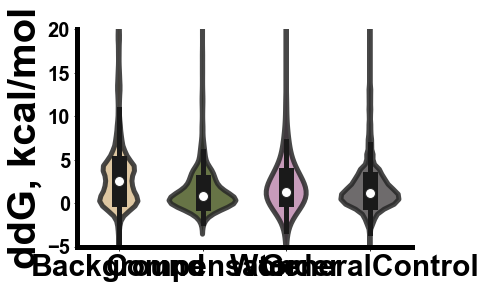

In [17]:

hue_list = ['Wonder',
       'GeneralControl','Compensator','Background']

df1 = df1[df1['#Pair_Type'].isin(hue_list)]



mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 20, 15 

sns_plot = sns.violinplot(df1['#Pair_Type'], df1['ddG_pair_Rec'],
                         palette = pics.colormap,linewidth=5)

for violin, alpha in zip(sns_plot.collections[::2], [0.85 for i in range(4)]):
    violin.set_alpha(alpha)
#plt.title(fig.axes[0].get_title(), loc='center', pad = 10,
         #size = 20)
    
plt.setp(sns_plot.artists, edgecolor = 'k', facecolor='w') #ставим черный и белые цвета
plt.setp(sns_plot.lines, color='k')

sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("whitegrid")#белый фон
sns_plot.grid(False)#убрать полоски
sns_plot.spines['bottom'].set_color('black')


sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку

plt.ylabel('ddG, kcal/mol',size = 40, weight='extra bold') 
plt.xlabel('', size=80,  weight='extra bold', labelpad=50)
plt.xticks(size=30, weight='bold', ha="center" )
plt.yticks(size=20, weight='bold', ha="right" )
plt.ylim((-5,20))
fig = sns_plot.get_figure()
#fig.savefig(compeletename+ 'Fig3_ddg.png', bbox_inches="tight", dpi = 100)

In [18]:
df1.shape

(233778, 78)

In [20]:
types = df1['#Pair_Type'].unique().tolist()

In [22]:
for i in range(4):
    for k in range(i+1,4):
        x = df1[df1['#Pair_Type']==types[i]]['ddG_pair_Rec']
        y = df1[df1['#Pair_Type']==types[k]]['ddG_pair_Rec']
        print(types[i], types[k])
        print(calc_U(x,y))

Background Compensator
(0.659, 5.327725464936222e-160)
Background Wonder
(0.592, 0.00010139292929392144)
Background GeneralControl
(0.612, 0.0)
Compensator Wonder
(0.582, 0.000821985466265872)
Compensator GeneralControl
(0.555, 5.079153417854049e-20)
Wonder GeneralControl
(0.527, 0.26264512401586027)


# universal

In [40]:
df1=df.dropna(subset=['ddG_A_Rec'])
df1 = df1[(df1['Effect_A']=='bad')]

In [42]:
df1['LongA'] = df1['Dataset'] + '_' +df1['Uniprot_AC'] +'_'+df1['Pos_A'].astype(str)
df1['LongC'] = df1['Dataset'] + '_' +df1['Uniprot_AC'] +'_'+df1['Pos_C'].astype(str)

dfcompen = df1[df1['#Pair_Type']=='Compensator'].copy()
dfcompen = dfcompen[dfcompen['Dataset'].str.contains('mave')]

df_degree = dfcompen['LongC'].value_counts()
dfcompen = pd.merge(dfcompen,df_degree, how='left', left_on='LongC', right_index=True)
dfcompen.head()
dfcompen_drop = dfcompen.drop_duplicates(subset='LongC_x')
len(dfcompen_drop)

dflabel = pd.DataFrame(columns=['LongC_x','Universal'])

for elem in dfcompen_drop['Dataset'].unique():
    dflocal = dfcompen_drop[dfcompen_drop['Dataset']==elem]
    tresh = dflocal[['LongC_y']].quantile(.9)
    dflocal['Universal'] = (dflocal['LongC_y'] >= tresh[0]).astype(int)
    dflabel = dflabel.append(dflocal[['LongC_x','Universal']])
    

dfcompen = pd.merge(dfcompen, dflabel[['LongC_x','Universal']],
                                how='left')


dfcompen = dfcompen[dfcompen.ddG_C_Rec.apply(is_float)] 

dfcompen_short = dfcompen.drop_duplicates(subset=['Uniprot_AC',
                                          'Pos_A','A1', 'A2', 'C1', 'C2',
                                          'Pos_C',
                                          'Dataset'])

In [43]:
dfcompen_short['Universal'] = dfcompen_short['Universal'].replace(0,'Non-universal')
dfcompen_short['Universal'] = dfcompen_short['Universal'].replace(1,'Universal')

dfcompen_short['ddG_C_Rec'] = dfcompen_short['ddG_C_Rec'].astype(float)



In [44]:
dfcompen_short = dfcompen_short[dfcompen_short['ddG_C_Rec']<15]

In [47]:
dfcompen_short

,#Pair_Type,Dataset,Uniprot_AC,Pos_A,A1,A2,Pos_C,C1,C2,Score_A,Score_C,Score_AC,PMD_Phen,Effect_A,Effect_C,Effect_AC,Max_PDB_ID_A,Max_Chain_A,Max_Residue-ID_A,Max_Residue_AA_type_A,Max_Sequence_identity_A,Max_Coverage_A,Max_Resolution_A,Max_RIN_A,Max_Chain_interaction_partners_A,Max_Small_molecules_partners_A,Short_Max_RIN_A,Max_Iden_A1 match,Max_PDB_ID_C,Max_Chain_C,Max_Residue-ID_C,Max_Residue_AA_type_C,Max_Sequence_identity_C,Max_Coverage_C,Max_Resolution_C,Max_RIN_C,Max_Chain_interaction_partners_C,Max_Small_molecules_partners_C,Short_Max_RIN_C,Max_Iden_C1_match,Rec_PDB_ID_A,Rec_Chain_A,Rec_Residue-ID_A,Rec_Residue_AA_type_A,Rec_Sequence_identity_A,Rec_Coverage_A,Rec_Resolution_A,Rec_RIN_A,Rec_Chain_interaction_partners_A,Rec_Small_molecules_partners_A,Short_Rec_RIN_A,Rec_A1_match,Rec_PDB_ID_C,Rec_Chain_C,Rec_Residue-ID_C,Rec_Residue_AA_type_C,Rec_Sequence_identity_C,Rec_Coverage_C,Rec_Resolution_C,Rec_RIN_C,Rec_Chain_interaction_partners_C,Rec_Small_molecules_partners_C,Short_Rec_RIN_C,Rec_C1_match,Max_Chain_partners_A,Max_Chain_partners_C,Rec_Chain_partners_A,Rec_PDB_AA_C,Rec_Chain_partners_C,id_pair_Max,id_A_Max,id_C_Max,id_pair_Rec,id_A_Rec,id_C_Rec,ddG_pair_Rec,ddG_A_Rec,ddG_C_Rec,LongA,LongC_x,LongC_y,Universal
0,Compensator,maveDB_2,P63279,72,P,T,131,A,E,-2.91749,-0.890139,-0.166338,?,bad,neutral,neutral,1a3s,A,72,P,1.0,1.0,2.8,Core,?,?,Core,1,1a3s,A,131,A,1.0,1.0,2.8,Surface,?,?,Surface,1,2vrr,A,72,P,1.0,0.9936709999999999,2.22,Surface,?,?,Surface,1,2vrr,A,131,A,1.0,0.9936709999999999,2.22,Surface,?,?,Surface,1,?,?,?,?,?,378628,597773,602399,252179,377759,382062,4.835890,4.835890,-0.452879,maveDB_2_P63279_72,maveDB_2_P63279_131,1,Non-universal
1,Compensator,maveDB_2,P63279,2,S,N,150,A,N,-1.47971,-0.421116,0.162616,?,bad,neutral,neutral,1a3s,A,2,S,1.0,1.0,2.8,Surface,?,?,Surface,1,1a3s,A,150,A,1.0,1.0,2.8,Surface,?,?,Surface,1,4w5v,A,2,S,1.0,1.0,2.5,Protein interaction,B,?,PPI,1,4w5v,A,150,A,1.0,1.0,2.5,Surface,?,?,Surface,1,?,?,?,?,?,378629,597774,602400,252180,377760,382063,0.713869,0.713869,-0.470789,maveDB_2_P63279_2,maveDB_2_P63279_150,1,Non-universal
2,Compensator,maveDB_2,P63279,141,R,G,126,Q,R,-1.51138,0.119079,-0.423622,?,bad,neutral,neutral,1a3s,A,141,R,1.0,1.0,2.8,Surface,?,?,Surface,1,1a3s,A,126,Q,1.0,1.0,2.8,Surface,?,?,Surface,1,4w5v,A,141,R,1.0,1.0,2.5,Surface,?,?,Surface,1,4w5v,A,126,Q,1.0,1.0,2.5,Surface,?,?,Surface,1,?,?,?,?,?,378630,597775,602401,252181,377761,382064,0.844060,0.844060,0.086491,maveDB_2_P63279_141,maveDB_2_P63279_126,1,Non-universal
3,Compensator,maveDB_2,P63279,141,R,S,63,L,H,-1.44578,-0.285712,-0.25513,?,bad,neutral,neutral,1a3s,A,141,R,1.0,1.0,2.8,Surface,?,?,Surface,1,1a3s,A,63,L,1.0,1.0,2.8,Surface,?,?,Surface,1,4w5v,A,141,R,1.0,1.0,2.5,Surface,?,?,Surface,1,4w5v,A,63,L,1.0,1.0,2.5,Surface,?,?,Surface,1,?,?,?,?,?,378631,597776,602402,252182,377762,382065,0.521492,0.521492,1.770380,maveDB_2_P63279_141,maveDB_2_P63279_63,1,Non-universal
4,Compensator,maveDB_2,P63279,73,P,L,121,N,D,-3.36894,0.0475188,0.0881667,?,bad,neutral,neutral,1a3s,A,73,P,1.0,1.0,2.8,Core,?,?,Core,1,1a3s,A,121,N,1.0,1.0,2.8,Surface,?,?,Surface,1,4w5v,A,73,P,1.0,1.0,2.5,Core,?,?,Core,1,4w5v,A,121,N,1.0,1.0,2.5,Surface,?,?,Surface,1,?,?,?,?,?,378632,597777,602403,252183,377763,382066,4.551490,4.551490,0.599562,maveDB_2_P63279_73,maveDB_2_P63279_121,2,Non-universal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,Compensator,maveDB_17,P01100,179,L,S,191,E,Q,-0.710146,-0.047695,-0.177044,?,bad,neutral,neutral,2wt7,A,179,L,1.0,0.16578900000000002,2.3,Protein interaction,B,?,PPI,1,2wt7,A,191,E,1.0,0.16578900000000002,2.3,Surface,?,?,Surface,1,6ucl,A,197,L,0.783333,0.157895,2.21,Surface,?,?,Surface,1,6ucl,A,209,E,0.783333,0.157895,2

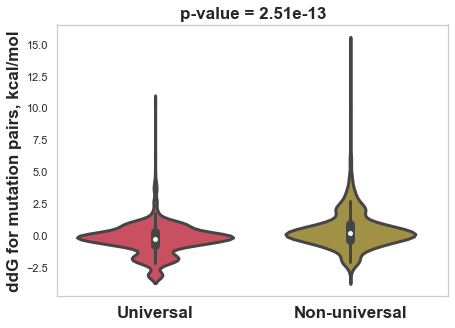

In [50]:
sns.set(rc={'figure.figsize':(7,5)})
sns.set_style("whitegrid")
fig = sns.violinplot(x=dfcompen_short['Universal'].astype(str),
               y=dfcompen_short['ddG_C_Rec'].astype(float),palette=colormap,
                    order = ['Universal','Non-universal'],linewidth=3)
fig.grid(False)

one = dfcompen_short[dfcompen_short['Universal']=='Non-universal']['ddG_C_Rec'].astype(float)
two = dfcompen_short[dfcompen_short['Universal']=='Universal']['ddG_C_Rec'].astype(float)

fig.set_ylabel('ddG for mutation pairs, kcal/mol',fontsize=17,fontweight='bold')
fig.set_xlabel('')

fig.set_title('p-value = 2.51e-13',fontdict={'fontsize':17,
                                                                       'fontweight':'bold'})
#fig.xaxis.set_tick_params(labelsize=17, weight='bold')
plt.xticks(size=17, weight='bold')
fig.set_xlabel('')

                 

#fig.set_ylim((-7,10))                         
fig = fig.get_figure()


#fig.savefig('/Users/azbukinanadezda/Google Диск/Курсач 2021/fig4c.png', dpi=200,bbox_inches='tight', pad_inches=0.5)

# paired universal

In [51]:
df1=df.dropna(subset=['ddG_pair_Rec'])
df1 = df1[(df1['Effect_A']=='bad')]

In [52]:
df1['LongA'] = df1['Dataset'] + '_' +df1['Uniprot_AC'] +'_'+df1['Pos_A'].astype(str)
df1['LongC'] = df1['Dataset'] + '_' +df1['Uniprot_AC'] +'_'+df1['Pos_C'].astype(str)

dfcompen = df1[df1['#Pair_Type']=='Compensator'].copy()
dfcompen = dfcompen[dfcompen['Dataset'].str.contains('mave')]

df_degree = dfcompen['LongC'].value_counts()
dfcompen = pd.merge(dfcompen,df_degree, how='left', left_on='LongC', right_index=True)
dfcompen.head()
dfcompen_drop = dfcompen.drop_duplicates(subset='LongC_x')
len(dfcompen_drop)

dflabel = pd.DataFrame(columns=['LongC_x','Universal'])

for elem in dfcompen_drop['Dataset'].unique():
    dflocal = dfcompen_drop[dfcompen_drop['Dataset']==elem]
    tresh = dflocal[['LongC_y']].quantile(.9)
    dflocal['Universal'] = (dflocal['LongC_y'] >= tresh[0]).astype(int)
    dflabel = dflabel.append(dflocal[['LongC_x','Universal']])
    

dfcompen = pd.merge(dfcompen, dflabel[['LongC_x','Universal']],
                                how='left')


dfcompen = dfcompen[dfcompen.ddG_pair_Rec.apply(is_float)] 

dfcompen_short = dfcompen.drop_duplicates(subset=['Uniprot_AC',
                                          'Pos_A','A1', 'A2', 'C1', 'C2',
                                          'Pos_C',
                                          'Dataset'])

In [54]:
dfcompen_short['Universal'] = dfcompen_short['Universal'].replace(0,'Non-universal')
dfcompen_short['Universal'] = dfcompen_short['Universal'].replace(1,'Universal')

dfcompen_short['FoldXddG'] = dfcompen_short['ddG_pair_Rec'].astype(float)



In [55]:
dfcompen_short = dfcompen_short[dfcompen_short['ddG_pair_Rec']<15]

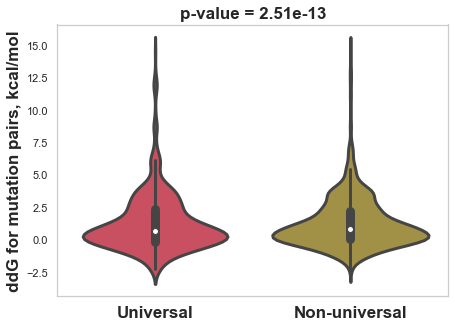

In [56]:
sns.set(rc={'figure.figsize':(7,5)})
sns.set_style("whitegrid")
fig = sns.violinplot(x=dfcompen_short['Universal'].astype(str),
               y=dfcompen_short['ddG_pair_Rec'].astype(float),palette=colormap,
                    order = ['Universal','Non-universal'],linewidth=3)
fig.grid(False)

one = dfcompen_short[dfcompen_short['Universal']=='Non-universal']['ddG_pair_Rec'].astype(float)
two = dfcompen_short[dfcompen_short['Universal']=='Universal']['ddG_pair_Rec'].astype(float)

fig.set_ylabel('ddG for mutation pairs, kcal/mol',fontsize=17,fontweight='bold')
fig.set_xlabel('')

fig.set_title('p-value = 2.51e-13',fontdict={'fontsize':17,
                                                                       'fontweight':'bold'})
#fig.xaxis.set_tick_params(labelsize=17, weight='bold')
plt.xticks(size=17, weight='bold')
fig.set_xlabel('')

                 

#fig.set_ylim((-7,10))                         
fig = fig.get_figure()


#fig.savefig('/Users/azbukinanadezda/Google Диск/Курсач 2021/fig4c.png', dpi=200,bbox_inches='tight', pad_inches=0.5)